In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import torch as tc
import importlib
# import cupy as cp
from sklearn.model_selection import KFold

from model import ffnn
importlib.reload(ffnn)
from model.ffnn import FFNN
tc.autograd.set_grad_enabled(False)
        
# if tc.cuda.is_available():
#     print("CUDA tersedia!")
# else:
#     print("CUDA tidak tersedia!")
    

device = tc.device("cuda" if tc.cuda.is_available() else "cpu")
tc.set_default_device(device)
print("Using CUDA device:", tc.cuda.get_device_name(device))


# cp.cuda.Device(0).use()




AssertionError: Torch not compiled with CUDA enabled

In [2]:
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data.astype(np.float64)
y = mnist.target.astype(np.int32)


X = X / 255.0
# print(X)
print("Dataset MNIST_784 dimuat: X shape:", X.shape, " y shape:", y.shape)

Dataset MNIST_784 dimuat: X shape: (70000, 784)  y shape: (70000,)


In [3]:

subset_size = 70000
indices = np.random.choice(np.arange(X.shape[0]), subset_size, replace=False)
X_subset = X.iloc[indices]
y_subset = y.iloc[indices]

X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)


print("Data subset: Training:", X_train.shape, "Testing:", X_test.shape)

Data subset: Training: (56000, 784) Testing: (14000, 784)


In [4]:
def one_hot(labels, num_classes):
    oh = np.zeros((labels.shape[0], num_classes))
    oh[np.arange(labels.shape[0]), labels] = 1.0
    return oh

num_classes = 10
y_train_oh = one_hot(y_train, num_classes)
y_test_oh = one_hot(y_test, num_classes)

In [ ]:
# mlp = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=100000, random_state=42, learning_rate_init=0.001, batch_size=200, verbose=True)

# start_time = time.time()
# mlp.fit(X_train, y_train)
# sklearn_training_time = time.time() - start_time

# #prediksi
# y_pred_sklearn = mlp.predict(X_test)
# accuracy_sklearn = np.mean(y_pred_sklearn == y_test)
# print("Akurasi MLPClassifier:", accuracy_sklearn)
# print("Waktu training MLPClassifier: {:.2f} detik".format(sklearn_training_time))

In [ ]:
# X_train = cp.asarray(X_train)
# y_train_oh = cp.asarray(y_train_oh)
# X_test = cp.asarray(X_test)
# y_test = cp.asarray(y_test)

# custom_model = FFNN(
#     [784, 64, 10],
#     activations_list=['relu', 'sigmoid'],
#     loss_function='mse',  
#     weight_init='random_uniform',
#     init_params={'lower': -1, 'upper': 1}
# )

# epochs_custom = 10000  
# batch_size_custom = 200
# lr_custom = 0.001

# start_time = time.time()
# history_custom = custom_model.train(X_train, y_train_oh, epochs=epochs_custom, batch_size=batch_size_custom, learning_rate=lr_custom, verbose=False)
# custom_training_time = time.time() - start_time
# print(f"Model custom selesai training dalam {custom_training_time:.2f} detik.")

# # Prediksi pada data test
# y_pred_custom = custom_model.forward(X_test)
# # y_pred_custom.data adalah NumPy array, sehingga gunakan np.argmax dengan parameter axis
# y_pred_custom_labels = cp.argmax(y_pred_custom, axis=1)
# accuracy_custom = cp.mean(y_pred_custom_labels == y_test)
# print("Akurasi model custom FFNN:", accuracy_custom)

In [ ]:
# X_train = np.asarray(X_train)
# y_train_oh = np.asarray(y_train_oh)
# X_test = np.asarray(X_test)
# y_test = np.asarray(y_test)

# k_folds = 5 
# epochs_custom = 100
# batch_size_custom = 200
# lr_custom = 0.001

# kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)


# fold_accuracies = []
# fold_losses = []

# print(f"Melakukan {k_folds}-Fold Cross Validation...\n")

# for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
#     print(f"Fold {fold+1}/{k_folds}")

#     X_train_fold = X_train[train_idx]
#     y_train_fold = y_train_oh[train_idx]
#     X_val_fold = X_train[val_idx]
#     y_val_fold = y_train_oh[val_idx]
    
#     X_train_fold = tc.tensor(X_train_fold, dtype=tc.float32)
#     X_val_fold = tc.tensor(X_val_fold, dtype=tc.float32)
#     y_train_fold = tc.tensor(y_train_fold, dtype=tc.float32)
#     y_val_fold = tc.tensor(y_val_fold, dtype=tc.int64)    

#     custom_model = FFNN(
#         [784, 256, 128, 64, 32, 10],
#         activations_list=['relu', 'relu', 'relu', 'relu', 'softmax'],
#         loss_function='cce',
#         weight_init='he_xavier',
#         init_params={'lower': -1, 'upper': 1}
#     )

#     history_custom = custom_model.train(
#         X_train_fold, y_train_fold, 
#         X_val_fold, y_val_fold,
#         epochs=epochs_custom, 
#         batch_size=batch_size_custom, 
#         learning_rate=lr_custom, 
#         verbose=False
#     )

#     y_pred_val = custom_model.forward(X_val_fold)
#     y_pred_labels = tc.argmax(y_pred_val, dim=1)
#     y_true_labels = tc.argmax(y_val_fold, dim=1)

#     accuracy = (y_pred_labels == y_true_labels).float().mean().item()
#     fold_accuracies.append(accuracy)

#     val_loss = history_custom["val_loss"][-1] if "val_loss" in history_custom else None
#     fold_losses.append(val_loss)

#     print(f"✅ Fold {fold+1}: Akurasi = {accuracy:.8f}, Loss = {val_loss:.8f}")

# # Rata-rata hasil Cross Validation
# avg_accuracy = np.mean(fold_accuracies)
# avg_loss = np.mean([l for l in fold_losses if l is not None])  

# print(f"\n**Hasil K-Fold Cross Validation ({k_folds}-fold)**:")
# print(f"-Rata-rata Akurasi: {avg_accuracy:.8f}")
# print(f"-Rata-rata Loss: {avg_loss:.8f}")

In [5]:
def plot_loss(metrics):
    if 'train_loss' not in metrics:
        print("Tidak ditemukan data 'train_loss' dalam metrics.")
        return
    train_loss = metrics['train_loss']
    iterations = list(range(1, len(train_loss) + 1))

    plt.figure(figsize=(8, 6))
    plt.plot(iterations, train_loss, linestyle='-', color='blue')
    plt.xlabel("Iterasi")
    plt.ylabel("Train Loss")
    plt.title("Training Loss per Iterasi")
    plt.grid(True)
    plt.show()
    degradation = []  
    for i in range(1, len(train_loss)):
        diff = train_loss[i - 1] - train_loss[i]
        degradation.append(diff)
    if degradation:
        avg_degradation = sum(degradation) / len(degradation)
    else:
        avg_degradation = 0

    print("Average degradation rate (loss drop per iteration):", avg_degradation)
    if degradation:
        plt.figure(figsize=(10, 6))
        plt.bar(iterations[1:], degradation, color='orange', alpha=0.7, label='Loss Drop')
        plt.xlabel("Iterasi")
        plt.ylabel("Loss Drop (Penurunan Loss)")
        plt.title("Loss Drop (Degradation) per Iterasi")
        plt.grid(True)
        plt.legend()
        plt.show()

In [6]:
X_train = tc.tensor(np.asarray(X_train), dtype=tc.float32)
X_test = tc.tensor(np.asarray(X_test), dtype=tc.float32)
y_train_oh = tc.tensor(np.asarray(y_train_oh), dtype=tc.float32)
y_test = tc.tensor(np.asarray(y_test), dtype=tc.int64)

print(X_train.get_device())
custom_model = FFNN(
    [784, 400, 10],
    activations_list=['relu','softmax'],
    loss_function='cce',  
    weight_init='he_xavier',
    init_params={'lower': -1, 'upper': 1},
    # regularization='L2'
    # use_rmsnorm=True
)
epochs_custom = 2000
batch_size_custom = 200
lr_custom = 0.001

start_time = time.time()
history_custom = custom_model.train(X_train, y_train_oh, epochs=epochs_custom, batch_size=batch_size_custom, learning_rate=lr_custom, verbose=True, stop_in_convergence=True)
custom_training_time = time.time() - start_time
print(f"Model custom selesai training dalam {custom_training_time:.2f} detik.")





# 107,32s tc cpu
# 158,16s tc gpu
# 215,52s cp gpu
# 230,48s np cpu

# 555.06 detik

# 4000 20m

# Model custom selesai training dalam 1135.40 detik. GPU
# Akurasi model custom FFNN: 0.9748571515083313

# Model custom selesai training dalam 1193.06 detik. CPU
# Akurasi model custom FFNN: 0.9740714430809021

# Model custom selesai training dalam 733.88 detik.
# Akurasi model custom FFNN: 0.9735714197158813


-1
Epoch 1/2000 - Train Loss: 2.78079932
Epoch 2/2000 - Train Loss: 2.59840119
Epoch 3/2000 - Train Loss: 2.50006751
Epoch 4/2000 - Train Loss: 2.41677117
Epoch 5/2000 - Train Loss: 2.35133160
Epoch 6/2000 - Train Loss: 2.29561660
Epoch 7/2000 - Train Loss: 2.24182047
Epoch 8/2000 - Train Loss: 2.18830124
Epoch 9/2000 - Train Loss: 2.13610174
Epoch 10/2000 - Train Loss: 2.08384816
Epoch 11/2000 - Train Loss: 2.03377980
Epoch 12/2000 - Train Loss: 1.98421869
Epoch 13/2000 - Train Loss: 1.93490001
Epoch 14/2000 - Train Loss: 1.88678685
Epoch 15/2000 - Train Loss: 1.84000341
Epoch 16/2000 - Train Loss: 1.79376349
Epoch 17/2000 - Train Loss: 1.74899430
Epoch 18/2000 - Train Loss: 1.70553439
Epoch 19/2000 - Train Loss: 1.66233198
Epoch 20/2000 - Train Loss: 1.62086957
Epoch 21/2000 - Train Loss: 1.58045008
Epoch 22/2000 - Train Loss: 1.54137784
Epoch 23/2000 - Train Loss: 1.50322677
Epoch 24/2000 - Train Loss: 1.46624468
Epoch 25/2000 - Train Loss: 1.43103435
Epoch 26/2000 - Train Loss: 1.3

In [ ]:
model_path = "custom_model.pth"
custom_model.save(model_path)

In [ ]:
loaded_model = FFNN.load("custom_model.pth")

# Prediksi 
y_pred_custom = loaded_model.forward(X_test)
y_pred_custom_labels = tc.argmax(y_pred_custom.data, dim=1)
accuracy_custom = (y_pred_custom_labels == y_test).float().mean().item()
print("Akurasi model custom FFNN:", accuracy_custom)


plot_loss(history_custom)

In [ ]:
loaded_model.plot_gradients_distribution([0,1])

In [ ]:
loaded_model.plot_weight_distribution([0,1])


Akurasi model custom FFNN: 0.93621426820755


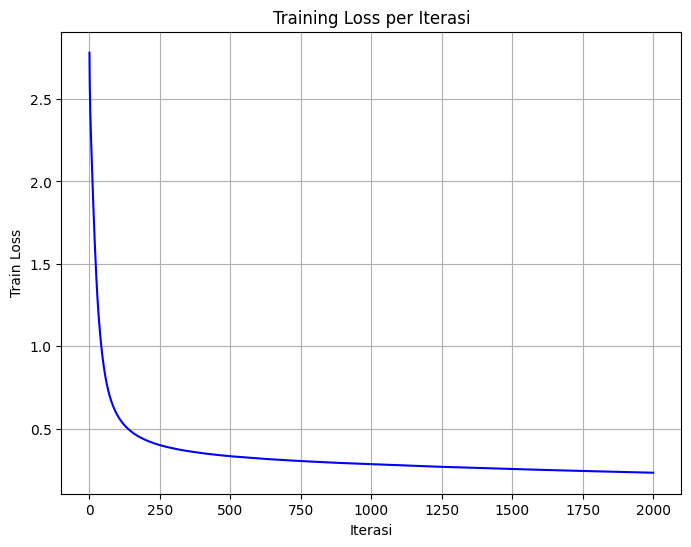

Average degradation rate (loss drop per iteration): 0.0012746815532227566


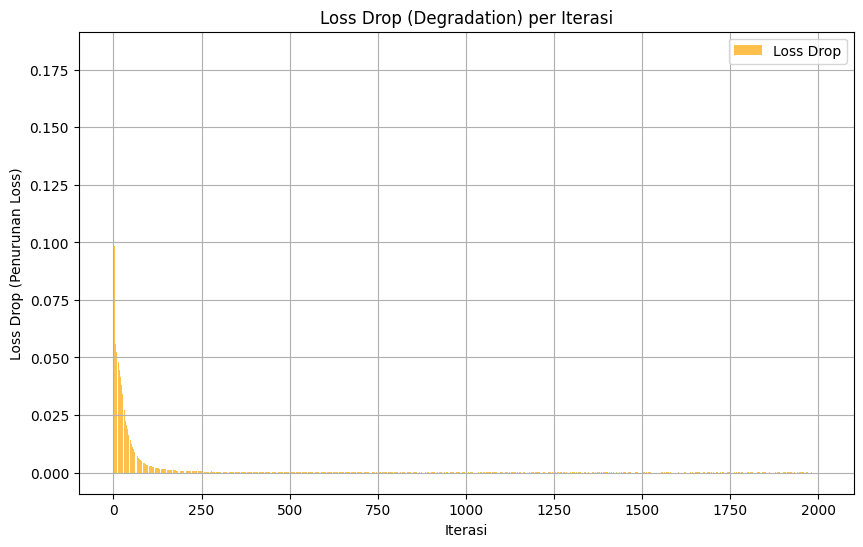

In [7]:


# Prediksi 
y_pred_custom = custom_model.forward(X_test)
y_pred_custom_labels = tc.argmax(y_pred_custom.data, dim=1)
accuracy_custom = (y_pred_custom_labels == y_test).float().mean().item()
print("Akurasi model custom FFNN:", accuracy_custom)


plot_loss(history_custom)

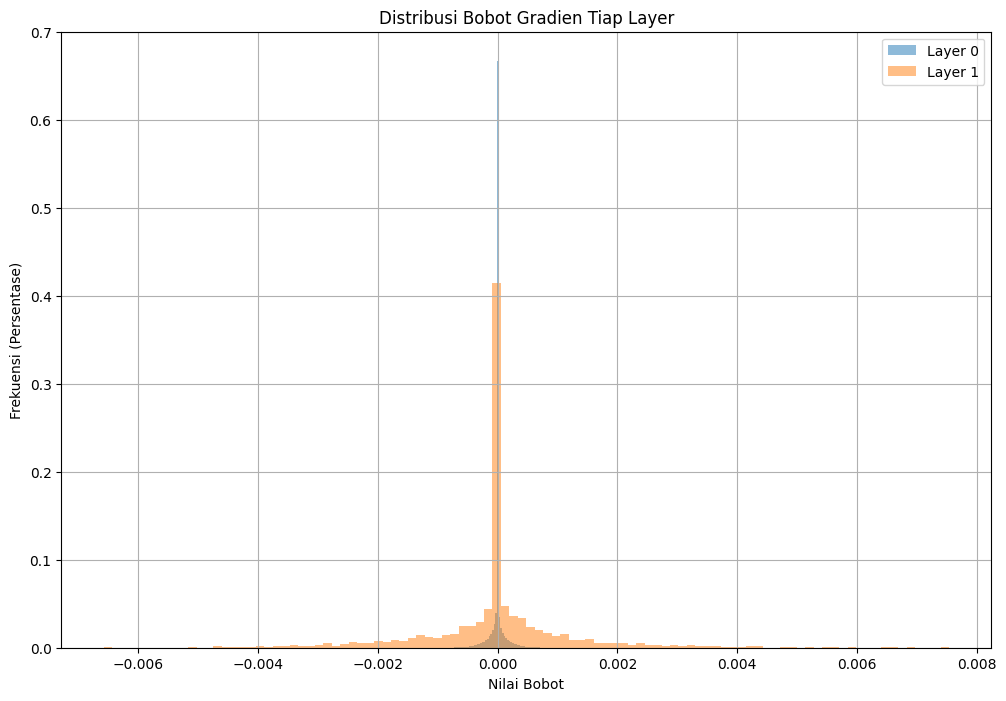

In [8]:
custom_model.plot_gradients_distribution([0,1])

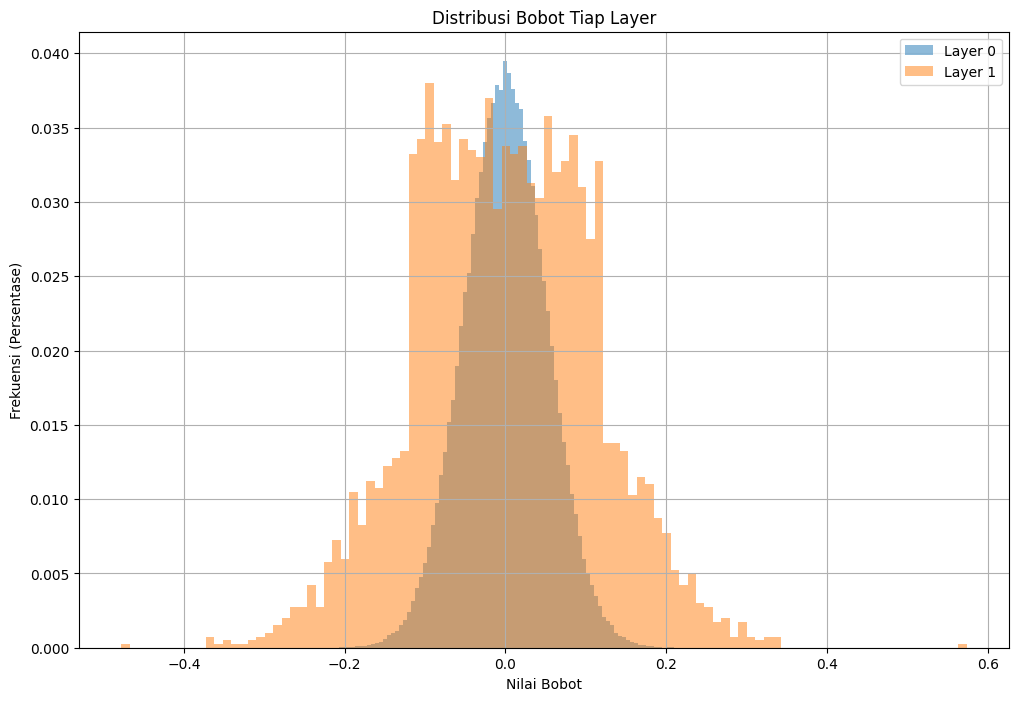

In [9]:
custom_model.plot_weight_distribution([0,1])


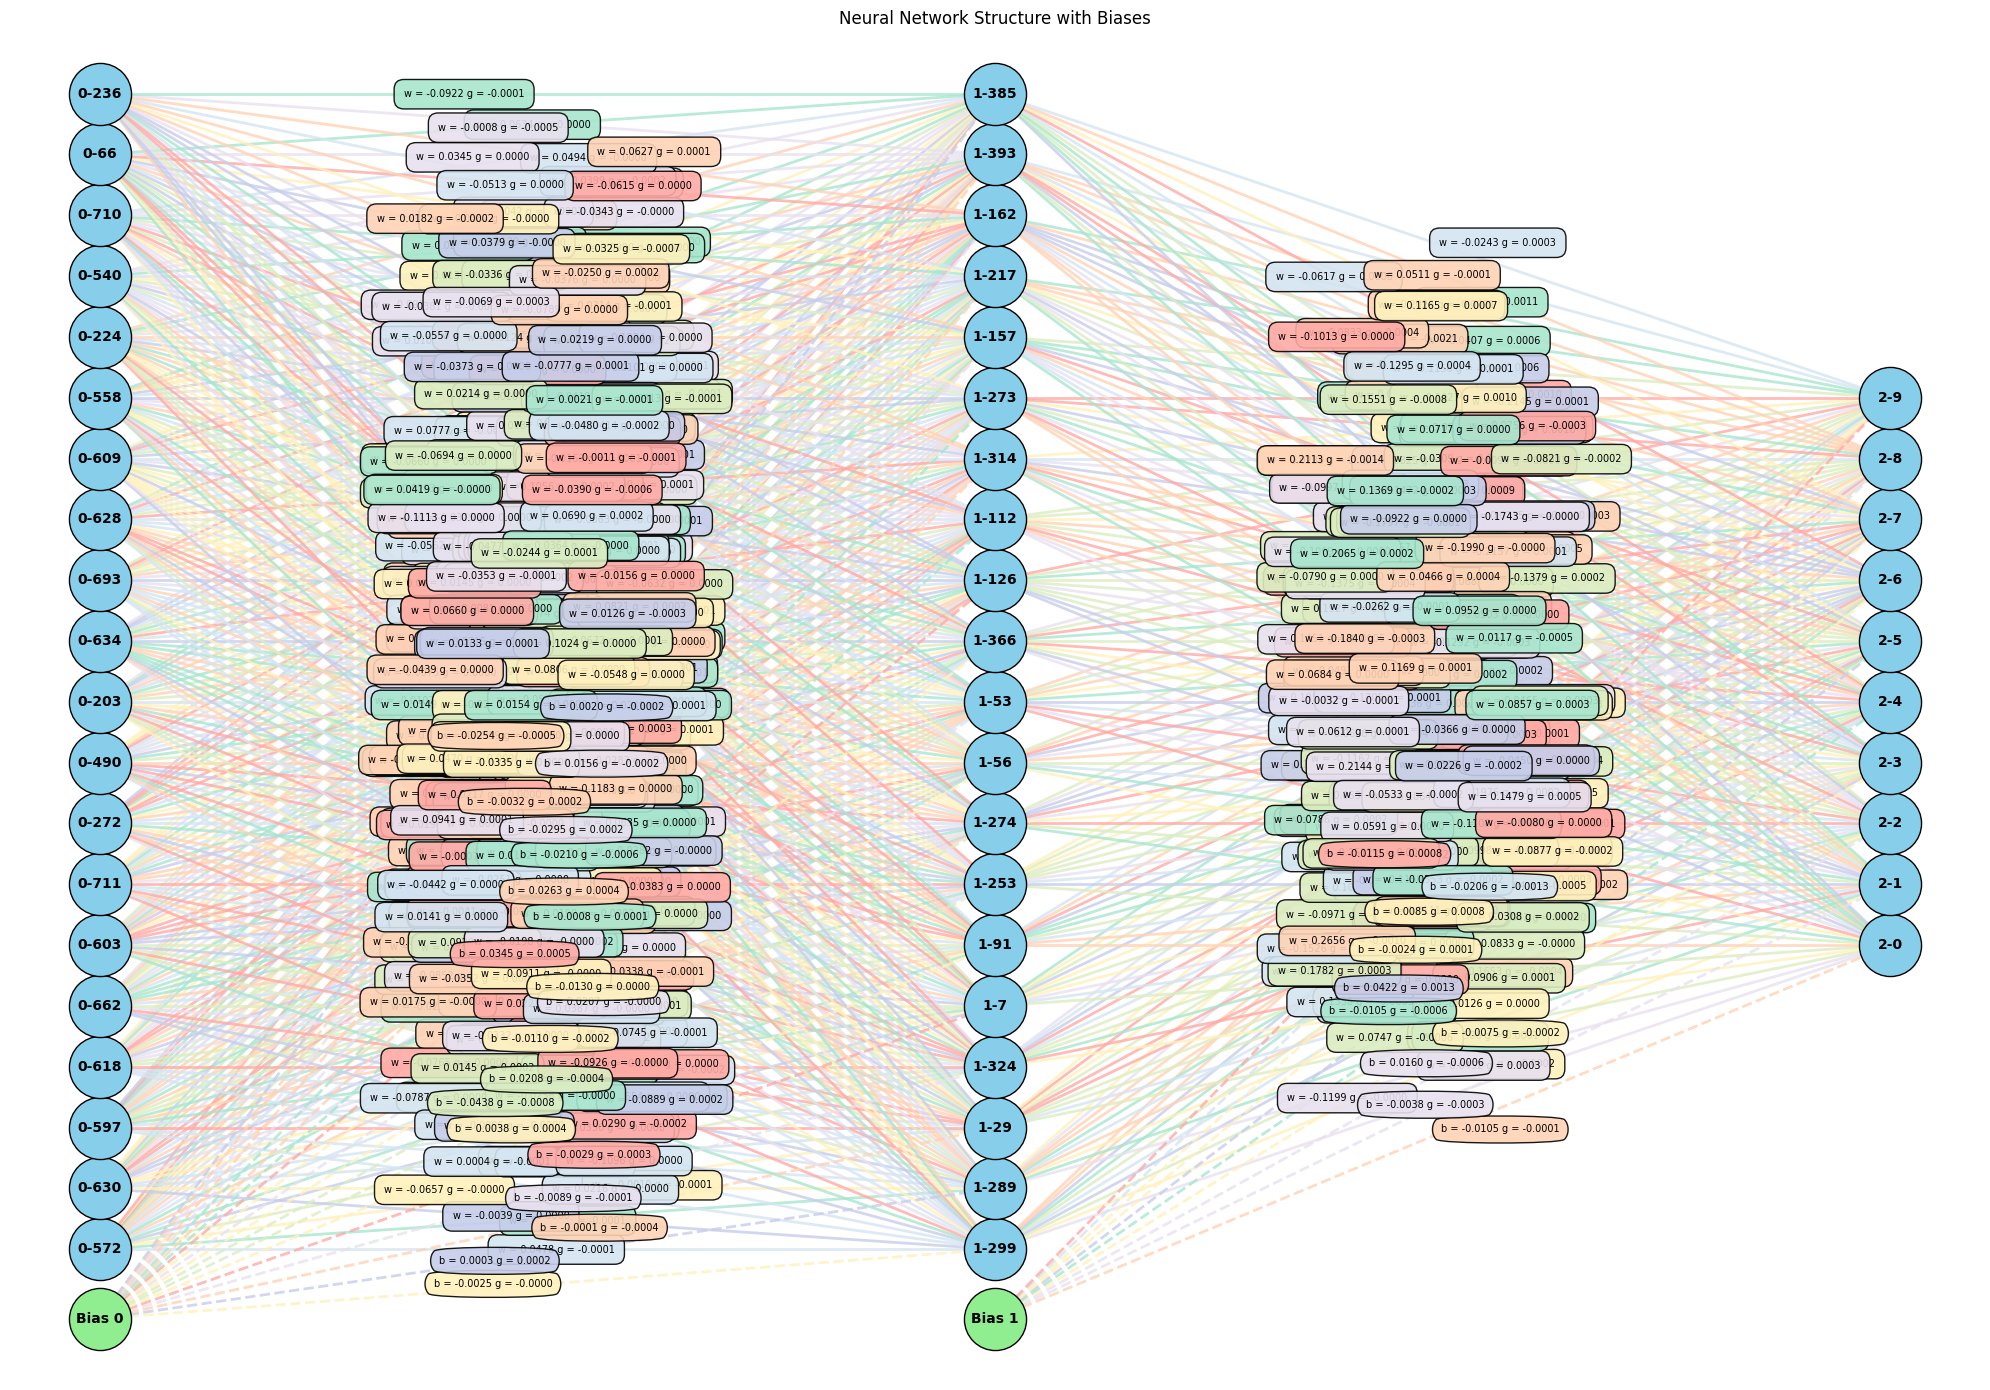

In [10]:
custom_model.plot_network_structure(20)